# Example 2


### Identifying the reaction energy profile of multiple Diels-Alder reaction

This workflow includes:

i) CREST conformer sampling \
ii) Gaussian geometry optimizations and frequency calcs (B3LYP/def2TZVP) \
iii) Dixing errors and imaginary frequencies of the output LOG files \
iv) ORCA single-point energy corrections (SPC) using DLPNO-CCSD(T)/cc-pV(DT)Z \
v) Boltzmann weighted thermochemistry calculation with GoodVibes at 298.15 K

#### Steps involved in this example

- Step 1: Importing AQME and other python modules
- Step 2: Determining distance and angle constraints for TSs
- Step 3: CSEARCH conformational sampling
- Step 4: Creating Gaussian input files for optimization and frequency with QPREP
- Step 5: Running Gaussian inputs for optimization and frequency calcs externally
- Step 6: QCORR analysis
- Step 7: Resubmission of the new jobs (if any)
- Step 8: Creating DLPNO input files for ORCA single-point energy calculations
- Step 9: Running ORCA inputs for single point energy calcs externally
- Step 10: Calculating PES with goodvibes

###  Step 1: Importing AQME and other python modules

In [1]:
import os, glob, subprocess
import shutil
from pathlib import Path
from aqme.csearch import csearch
from aqme.qprep import qprep
from aqme.qcorr import qcorr
from rdkit import Chem
import pandas as pd

[11:38:24] Enabling RDKit 2019.09.3 jupyter extensions
RDKit WARNING: [11:38:24] Enabling RDKit 2019.09.3 jupyter extensions


### Step 2: Determining distance and angle constraints for TSs

The new mapped smiles for checking numbers used in constraints is: C1([H:8])=[C:1]([H:9])[C:2]([H:10])=[C:3]([H:11])[C:4]1([H:12])[H:13].[C:5]1([H:14])=[C:6]([H:15])[C:7]1([H:16])[H:17]


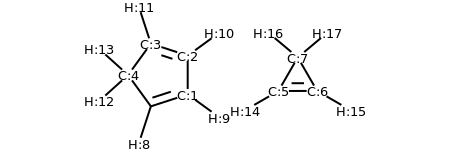

In [2]:
smi1 = 'C1=CC=CC1.C1=CC1'
mol1 = Chem.MolFromSmiles(smi1)
mol1 = Chem.AddHs(mol1)
for i,atom in enumerate(mol1.GetAtoms()):
    atom.SetAtomMapNum(i)
smi_new1 = Chem.MolToSmiles(mol1)
print('The new mapped smiles for checking numbers used in constraints is:', smi_new1)

mol1
# distance and angle constraints to include in the CSV file are:
# constraits_dist = [[3,5,2.35],[0,6,2.35]]
# constraits_dihedral = [[0,3,5,6,0]]

The new mapped smiles for checking numbers used in constraints is: C1([H:9])=[C:1]([H:10])[C:2]([H:11])=[C:3]([H:12])[C:4]1([H:13])[H:14].[C:5]1([H:15])=[C:6]([H:16])[C:7]([H:17])([H:18])[C:8]1([H:19])[H:20]


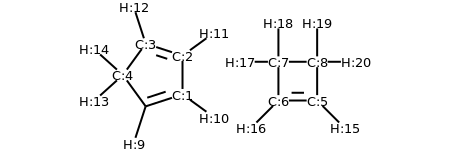

In [3]:
smi1 = 'C1=CC=CC1.C1=CCC1'
mol1 = Chem.MolFromSmiles(smi1)
mol1 = Chem.AddHs(mol1)
for i,atom in enumerate(mol1.GetAtoms()):
    atom.SetAtomMapNum(i)
smi_new1 = Chem.MolToSmiles(mol1)
print('The new mapped smiles for checking numbers used in constraints is:', smi_new1)

mol1
# distance and angle constraints to include in the CSV file are:
# constraits_dist = [[3,5,2.4],[0,6,2.4]]
# constraits_dihedral = [[0,3,5,6,0]]

The new mapped smiles for checking numbers used in constraints is: C1([H:10])=[C:1]([H:11])[C:2]([H:12])=[C:3]([H:13])[C:4]1([H:14])[H:15].[C:5]1([H:16])=[C:6]([H:17])[C:7]([H:18])([H:19])[C:8]([H:20])([H:21])[C:9]1([H:22])[H:23]


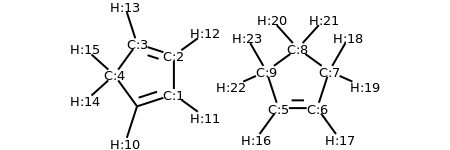

In [4]:
smi1 = 'C1=CC=CC1.C1=CCCC1'
mol1 = Chem.MolFromSmiles(smi1)
mol1 = Chem.AddHs(mol1)
for i,atom in enumerate(mol1.GetAtoms()):
    atom.SetAtomMapNum(i)
smi_new1 = Chem.MolToSmiles(mol1)
print('The new mapped smiles for checking numbers used in constraints is:', smi_new1)

mol1
# distance and angle constraints to include in the CSV file are:
# constraits_dist = [[3,10,2.35],[0,11,2.35]]
# constraits_dihedral = [[0,3,10,11,0]]

### Step 3: CSEARCH conformational sampling

In [5]:
data = pd.read_csv('example2.csv') # read the CSV file with SMILES strings and constraints for TSs (from Step 2)
csearch(input='example2.csv',program='crest',cregen=True,cregen_keywords='--ethr 0.1 --rthr 0.2 --bthr 0.3 --ewin 1')

AQME v 1.4.0 2022/12/09 11:38:24 
Citation: AQME v 1.4.0, Alegre-Requena, J. V.; Sowndarya, S.; Perez-Soto, R.; Alturaifi, T. M.; Paton, R. S., 2022. https://github.com/jvalegre/aqme



Starting CSEARCH with 10 job(s) (SDF, XYZ, CSV, etc. files might contain multiple jobs/structures inside)



   ----- Diene -----


o  Applying filters to initial conformers


   ----- Do1 -----


o  Applying filters to initial conformers


   ----- Do2 -----


o  Applying filters to initial conformers


   ----- Do3 -----


o  Applying filters to initial conformers


   ----- TS1 -----


   ----- TS2 -----


   ----- TS3 -----


   ----- P1 -----


o  Applying filters to initial conformers


   ----- P2 -----


o  Applying filters to initial conformers


   ----- P3 -----


o  Applying filters to initial conformers


Time CSEARCH: 2238.95 seconds




### Step 4: Creating Gaussian input files for optimization and frequency with QPREP

In [6]:
program = 'gaussian'
mem='72GB'
nprocs=16

# COM files for the TSs
sdf_TS_files = glob.glob('CSEARCH/TS*crest.sdf')
qm_input_TS = 'B3LYP/def2tzvp opt=(ts,calcfc,noeigen) freq'
qprep(files=sdf_TS_files,program=program,qm_input=qm_input_TS,mem=mem,nprocs=nprocs)

# COM files for intermediates, reagents and products
sdf_INT_files = glob.glob('CSEARCH/D*.sdf') + glob.glob('CSEARCH/P*.sdf')
qm_input_INT = 'B3LYP/def2tzvp opt freq'

qprep(files=sdf_INT_files,program=program,qm_input=qm_input_INT,mem=mem,nprocs=nprocs)

AQME v 1.4.0 2022/12/09 11:38:24 
Citation: AQME v 1.4.0, Alegre-Requena, J. V.; Sowndarya, S.; Perez-Soto, R.; Alturaifi, T. M.; Paton, R. S., 2022. https://github.com/jvalegre/aqme


o  TS1_crest successfully processed at /home/svss/Project-DBcg-Molecules/aqme/Example_workflows/End-to-end_Workflows/2-Diels_Alder_Reaction/Inputs-redo/QCALC

o  TS2_crest successfully processed at /home/svss/Project-DBcg-Molecules/aqme/Example_workflows/End-to-end_Workflows/2-Diels_Alder_Reaction/Inputs-redo/QCALC

o  TS3_crest successfully processed at /home/svss/Project-DBcg-Molecules/aqme/Example_workflows/End-to-end_Workflows/2-Diels_Alder_Reaction/Inputs-redo/QCALC


Time QPREP: 0.01 seconds


AQME v 1.4.0 2022/12/09 11:38:24 
Citation: AQME v 1.4.0, Alegre-Requena, J. V.; Sowndarya, S.; Perez-Soto, R.; Alturaifi, T. M.; Paton, R. S., 2022. https://github.com/jvalegre/aqme


o  Diene_crest successfully processed at /home/svss/Project-DBcg-Molecules/aqme/Example_workflows/End-to-end_Workflows/2-Diel

### Step 5: Running Gaussian inputs for optimization and frequency calcs externally

In [7]:
# Run the generated COM files (in the QCALC folder) with Gaussian

### Step 6: QCORR analysis

In [8]:
qcorr(files='QCALC/*.log',freq_conv='opt=(calcfc,maxstep=5)',mem=mem,nprocs=nprocs)

AQME v 1.4.0 2022/12/09 11:38:24 
Citation: AQME v 1.4.0, Alegre-Requena, J. V.; Sowndarya, S.; Perez-Soto, R.; Alturaifi, T. M.; Paton, R. S., 2022. https://github.com/jvalegre/aqme


o  Analyzing output files in /home/svss/Project-DBcg-Molecules/aqme/Example_workflows/End-to-end_Workflows/2-Diels_Alder_Reaction/Inputs-redo/QCALC


Diene_crest_conf_1.log: Termination = normal, Error type = none

Do1_crest_conf_1.log: Termination = normal, Error type = none

Do2_crest_conf_1.log: Termination = normal, Error type = none

Do3_crest_conf_1.log: Termination = normal, Error type = none

P1_crest_conf_1.log: Termination = normal, Error type = none

P2_crest_conf_1.log: Termination = normal, Error type = none

P3_crest_conf_1.log: Termination = normal, Error type = freq_no_conv

P3_crest_conf_2.log: Termination = normal, Error type = none

TS1_crest_conf_1.log: Termination = normal, Error type = none

TS2_crest_conf_1.log: Termination = normal, Error type = freq_no_conv

TS2_crest_conf_1_man.

### Step 7: Resubmission of unsuccessful calculations (if any) with suggestions from AQME

In [9]:
# Run the generated COM files (in fixed_inp_folder, see PATH in Step 8) with Gaussian

### Step 8: Creating DLPNO input files for ORCA single-point energy calculations

In [10]:
program = 'orca'
mem='16GB'
nprocs=8

qm_files = os.getcwd()+'/QCALC/success/*.log' # LOG files from Steps 6 and 8
destination =  os.getcwd()+'/SP' # folder where the ORCA output files are generated

# keyword lines for ORCA inputs
qm_input ='DLPNO-CCSD(T) def2-tzvpp def2-tzvpp/C\n'
qm_input += '%scf maxiter 500\n'
qm_input += 'end\n'
qm_input += '% mdci\n'
qm_input += 'Density None\n'
qm_input += 'end\n'
qm_input += '% elprop\n'
qm_input += 'Dipole False\n'
qm_input += 'end'

qprep(destination=destination,files=qm_files,program=program, qm_input=qm_input,mem=mem,nprocs=nprocs, suffix='DLPNO')

AQME v 1.4.0 2022/12/09 11:38:24 
Citation: AQME v 1.4.0, Alegre-Requena, J. V.; Sowndarya, S.; Perez-Soto, R.; Alturaifi, T. M.; Paton, R. S., 2022. https://github.com/jvalegre/aqme


o  Diene_crest_conf_1 successfully processed at /home/svss/Project-DBcg-Molecules/aqme/Example_workflows/End-to-end_Workflows/2-Diels_Alder_Reaction/Inputs-redo/SP

o  Do1_crest_conf_1 successfully processed at /home/svss/Project-DBcg-Molecules/aqme/Example_workflows/End-to-end_Workflows/2-Diels_Alder_Reaction/Inputs-redo/SP

o  Do2_crest_conf_1 successfully processed at /home/svss/Project-DBcg-Molecules/aqme/Example_workflows/End-to-end_Workflows/2-Diels_Alder_Reaction/Inputs-redo/SP

o  Do3_crest_conf_1 successfully processed at /home/svss/Project-DBcg-Molecules/aqme/Example_workflows/End-to-end_Workflows/2-Diels_Alder_Reaction/Inputs-redo/SP

o  P1_crest_conf_1 successfully processed at /home/svss/Project-DBcg-Molecules/aqme/Example_workflows/End-to-end_Workflows/2-Diels_Alder_Reaction/Inputs-redo/SP


### Step 9: Running ORCA inputs for single point energy calcs externally

In [11]:
# Run the generated COM files (in destination, see PATH in Step 9) with ORCA

### Step 10: Calculating PES with goodvibes

In [12]:
orca_files = os.getcwd()+'/SP/*.out' # folder where the OUT files from Step 10 are generated

# copy all the Gaussian LOG files and the ORCA OUT files into a new folder called GoodVibes_analysis (necessary to apply SPC corrections)
opt_files = glob.glob(qm_files)
spc_files = glob.glob(orca_files)
all_files = opt_files + spc_files

w_dir_main  = Path(os.getcwd())
GV_folder = w_dir_main.joinpath('GoodVibes_analysis')
GV_folder.mkdir(exist_ok=True, parents=True)

for file in all_files:
	shutil.copy(file, GV_folder)

# run GoodVibes
os.chdir(GV_folder)
subprocess.run(['python', '-m', 'goodvibes', '--xyz','--pes', '../pes.yaml','--graph','../pes.yaml','-c','1','--spc', 'DLPNO', '*.log',])
os.chdir(w_dir_main)

   GoodVibes v3.2 2022/12/09 18:44:13
   Citation: Luchini, G.; Alegre-Requena, J. V.; Funes-Ardoiz, I.; Paton, R. S. F1000Research, 2020, 9, 291.
   GoodVibes version 3.2 DOI: 10.12688/f1000research.22758.1

o  Requested: --xyz --pes ../pes.yaml --graph ../pes.yaml -c 1 --spc DLPNO 

   Temperature = 298.15 Kelvin   Concentration = 1.0 mol/L
   All energetic values below shown in Hartree unless otherwise specified.

o  Found vibrational scaling factor of 0.985 for B3LYP/def2TZVP level of theory
   I. M. Alecu, unpublished (2011).

   Entropic quasi-harmonic treatment: frequency cut-off value of 100.0 wavenumbers will be applied.
   QS = Grimme: Using a mixture of RRHO and Free-rotor vibrational entropies.
   REF: Grimme, S. Chem. Eur. J. 2012, 18, 9955-9964

   Combining final single point energy with thermal corrections.

   Structure                                       E_SPC             E        ZPE         H_SPC        T.S     T.qh-S      G(T)_SPC   qh-G(T)_SPC
   ***************